In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as signal
import pandas as pd

import obspy
import obspy.signal.trigger as trigger
from obspy import taup, geodetics

## setting client
from obspy.clients.fdsn import Client
client = Client("IRIS")

## Getting events and making a catalog

In [2]:
## retrieveing events within an area\n",
starttime = obspy.UTCDateTime("2020-09-01T00:00:00")
endtime = obspy.UTCDateTime("2020-09-10T00:00:00")

cat0 = client.get_events(starttime=starttime, endtime=endtime, minmagnitude=0, 
                         latitude=63.98,longitude=-143.99, maxradius=4)
cat1 = client.get_events(starttime=starttime, endtime=endtime, minmagnitude=1, 
                         latitude=63.98,longitude=-143.99, minradius = 4, maxradius=8)
cat2 = client.get_events(starttime=starttime, endtime=endtime, minmagnitude=2, 
                         latitude=63.98,longitude=-143.99, minradius = 8, maxradius=20)
cat3 = client.get_events(starttime=starttime, endtime=endtime, minmagnitude=3, 
                         latitude=63.98,longitude=-143.99, minradius = 20, maxradius=100)
cat4 = client.get_events(starttime=starttime, endtime=endtime, minmagnitude=4, 
                         latitude=63.98,longitude=-143.99, minradius = 100, maxradius=180)
cat_all = cat1 + cat2 + cat3 + cat4 + cat0

In [3]:
## getting 10 day data from SCRK station\n",
## get SCRK station
inventory = client.get_stations(network="AK", station="SCRK")
SCRK_station = inventory[0].stations[0]

SCRK_stream = client.get_waveforms("AK", "SCRK", "*", "BHZ", starttime=starttime, endtime=endtime)
st = SCRK_stream.merge(method=0,fill_value=0).detrend().filter("bandpass", freqmin=0.5, freqmax=24)
#st.plot()

### Picking using STA/LTA

In [5]:
trace = st[0]
trace_times = trace.times()
# trace_times = trace.stats.starttime + trace_times                 ## don't use for large datasets

fs = trace.stats.sampling_rate
cft = trigger.recursive_sta_lta(trace.data, int(5 * fs), int(10 * fs))
# trigger.plot_trigger(trace, cft, 1.2, 0.5)

## defione threshold above which to trigger (value from Tian et al.)
cft_threshold = 1.35

## define time offsets from theoretical arrival time within which to check for peak (value from Tian eta l.)
minsample_offset = int(10/trace.stats.delta)     ## search starting 10 s before
maxsample_offset = int(30/trace.stats.delta)     ## search till 30 s after

### Empty lists and datafram for catalog to dataframe conversion

In [6]:
sourcetime = []
arrivaltime = []
lat = []
lon = []
dep = []
magnitude = []
magnitudetype = []

### TauP model and arrival times

In [7]:
## intitalize a model using taup
model = taup.TauPyModel(model="prem")

cat_select = []

for event in cat_all:
    if len(event.origins) != 0 and len(event.magnitudes) != 0:
        station_event_dist_deg = geodetics.base.kilometers2degrees(geodetics.locations2degrees(event.origins[0].latitude, event.origins[0].longitude, SCRK_station.latitude, SCRK_station.longitude))
        model = obspy.taup.TauPyModel(model="prem")
        travel_time = model.get_travel_times(source_depth_in_km=max(0.0, event.origins[0].depth*1e-3), distance_in_degree=station_event_dist_deg)
        arrival_time_utc = event.origins[0].time + travel_time[0].time 
        arrival_time_relative = arrival_time_utc - trace.stats.starttime

        closest_stream_sample = np.absolute(trace_times-arrival_time_relative).argmin()
        search_range = range(closest_stream_sample - minsample_offset, closest_stream_sample + maxsample_offset)
        if np.max(cft[search_range]) >= cft_threshold:
            
            ## adding selected events to a new catalog
            cat_select.append(event)
            
            ## adding event information to empty lsits for conversion to dataframe
            sourcetime.append(event.origins[0].time)
            arrivaltime.append(arrival_time_utc)
            lat.append(event.origins[0].latitude)  
            lon.append(event.origins[0].longitude)
            dep.append(event.origins[0].depth)
            magnitude.append(event.magnitudes[0].mag)
            magnitudetype.append(event.magnitudes[0].magnitude_type )

In [8]:
## converting catalog lists as a dataframe
catalog_df = pd.DataFrame({'Latitude':lat,'Londitude':lon,'Depth':dep,
                   'Magnitude':magnitude,'Magnitude_type':magnitude_type, 
                   'SourceTime': sourcetime, 'SCRKarrivaltime': arrivaltime})
print(catalog_df)

     Latitude  Londitude    Depth  Magnitude Type  \
0     60.0405  -151.8620  68100.0        1.4   ml   
1     58.6717  -153.7575  87700.0        1.4   ml   
2     60.4163  -150.1208  34400.0        1.6   ml   
3     60.5051  -149.8854  29500.0        1.9   ml   
4     59.3961  -153.3090  98700.0        1.8   ml   
..        ...        ...      ...        ...  ...   
126   61.1206  -149.7645  36400.0        1.0   ml   
127   63.6004  -147.5228   4500.0        1.5   ml   
128   65.9358  -150.5064  17600.0        1.6   ml   
129   63.0716  -144.0795   3600.0        1.3   ml   
130   64.3926  -147.0379   9300.0        0.8   ml   

                      SourceTime              SCRKarrivaltime  
0    2020-09-08T14:47:00.083000Z  2020-09-08T14:47:09.476773Z  
1    2020-09-08T13:13:52.239000Z  2020-09-08T13:14:04.067671Z  
2    2020-09-08T09:31:39.221000Z  2020-09-08T09:31:44.467359Z  
3    2020-09-08T08:13:22.038000Z  2020-09-08T08:13:26.685787Z  
4    2020-09-08T08:07:16.199000Z  2020-09-0

## Figure 3 - segmented window ##

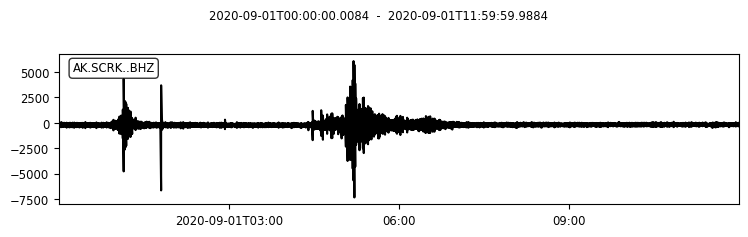

In [8]:
## getting 10 day data from the SCRK station ##
starttime_fig3 = obspy.UTCDateTime("2020-09-01T00:00:00")
endtime_fig3 = obspy.UTCDateTime("2020-09-01T12:00:00")

st3 = client.get_waveforms("AK", "SCRK", "*", "BHZ", starttime_fig3, endtime_fig3)

st3.plot()

## detrend and bandpass (nyquist = 25) ##
st3_new = st3.detrend().filter("bandpass", freqmin=0.5, freqmax=24)
tr_new = st3_new[0]

In [12]:
## truncating to match Yuan's trace ##
tr_trunc = tr_new.slice(starttime=starttime_fig3+3000, endtime=starttime_fig3+4200)
time = tr_trunc.times() 
data = tr_trunc.data

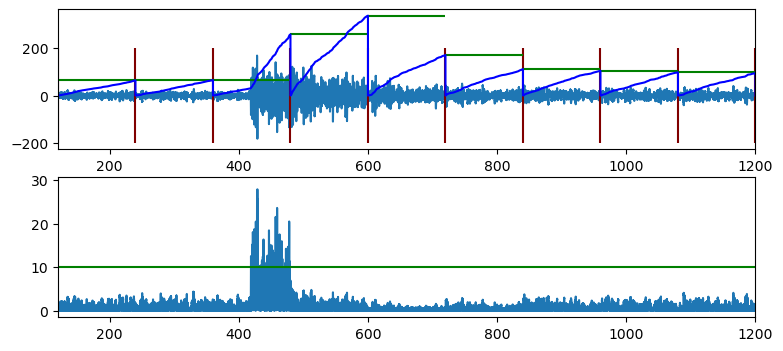

In [13]:
window_len = 120             ## defining window length in seconds ##

## getting bounds for each window ##
window_bound = time[time%window_len==0]
window_bound_idx = np.array(np.where(time%window_len==0)[0])

## storing window mean and (left, right) bounds as pairs for easy plotting
mean = []
mean_minbounds = []
mean_maxbounds = []

## arrays for diplacement ratio and cumulative sum of each window 
ratio = np.zeros_like(data)
running_sum = np.zeros_like(data)

prev_idx=window_bound_idx[0]
prev_mean = 1

for idx in window_bound_idx[1:]:
    
    curr_window = data[prev_idx:idx]
    curr_mean = np.sum(np.abs(curr_window))/len(curr_window)
    
    mean.append(curr_mean)
    mean_minbounds.append(prev_idx)
    mean_maxbounds.append(idx)
    
    ratio[prev_idx:idx] = np.abs(curr_window)/np.abs(prev_mean)          ## ratioing current window values using previous window mean 
    
    running_sum[prev_idx:idx] = np.cumsum(np.abs(curr_window))/len(curr_window)           ## cumulative sum of values normalized to window size 
    prev_idx=idx
    prev_mean = curr_mean


mean = np.array(mean)

fig, ax = plt.subplots(2,1, figsize=(9,4))
ax[0].plot(time,tr_trunc)
ax[0].vlines(window_bound, ymin = -200, ymax = 200, color="maroon")
ax[0].hlines(10*mean[:-1], xmin = time[mean_minbounds[1:]], xmax = time[mean_maxbounds[1:]], color = "green")
ax[0].plot(time, 10*running_sum, color="blue")
ax[0].set_xlim(120, time[-1])

ax[1].plot(time, ratio)
ax[1].hlines(10, xmin = time[0], xmax = time[-1], color = "green")
ax[1].set_xlim(120, time[-1])

plt.show()

## Figure 4 

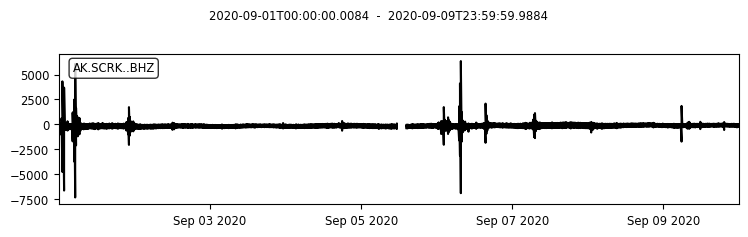

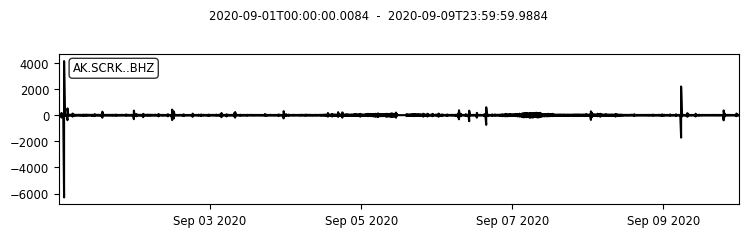

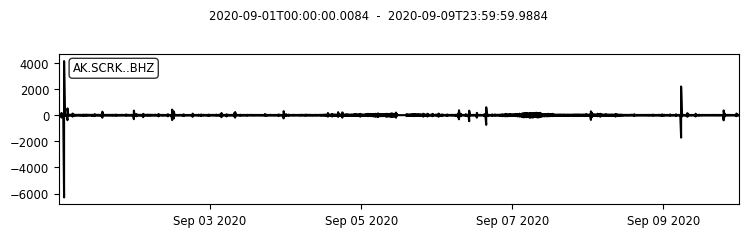

In [14]:
## getting 10 day data from the SCRK station ##
starttime_fig4 = obspy.UTCDateTime("2020-09-01T00:00:00")
endtime_fig4 = obspy.UTCDateTime("2020-09-10T00:00:00")

st4 = client.get_waveforms("AK", "SCRK", "*", "BHZ", starttime_fig4, endtime_fig4)

st4.plot()

## detrend and bandpass (nyquist = 25) ##
st4_new = st4.detrend().filter("bandpass", freqmin=0.5, freqmax=24)
st4_new.merge(method=0, fill_value=0)
tr4 = st4_new[0]

st4_new.plot()

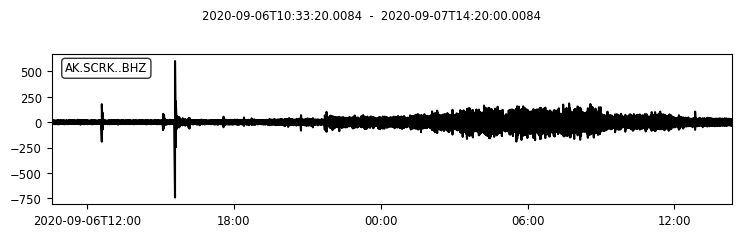

In [15]:
tr4_trunc = tr4.slice(starttime = starttime_fig4+470000, endtime = starttime_fig4 + 570000)
tr4_trunc.plot()

time4 = tr4_trunc.times() 
data4 = tr4_trunc.data

In [16]:
## Threshold trigger ## 
threshold = 120
trig_thresh_idx = np.where(np.abs(data4) >= threshold)



## segmented window trigger
window_len = 120             ## defining window length in seconds ##

## getting bounds for each window ##
window_bound = time4[time4%window_len==0]
window_bound_idx = np.array(np.where(time4%window_len==0)[0])

## storing window mean and (left, right) bounds as pairs for easy plotting
mean = []
mean_minbounds = []
mean_maxbounds = []
trig_segment = []

## arrays for diplacement ratio and cumulative sum of each window 
ratio = np.zeros_like(data4)
running_sum = np.zeros_like(data4)

prev_idx=window_bound_idx[0]
prev_mean = 1

for idx in window_bound_idx[1:]:
    
    curr_window = data4[prev_idx:idx]
    curr_mean = np.sum(np.abs(curr_window))/len(curr_window)
    
    mean.append(curr_mean)
    mean_minbounds.append(prev_idx)
    mean_maxbounds.append(idx)
    
    ratio[prev_idx:idx] = np.abs(curr_window)/np.abs(prev_mean)          ## ratioing current window values using previous window mean 
    
    running_sum[prev_idx:idx] = np.cumsum(np.abs(curr_window))/len(curr_window)           ## cumulative sum of values normalized to window size 
    
    # print(20*prev_mean)
    for i in range(prev_idx,idx):
        if data4[i] >= 20*prev_mean:
            trig_segment.append(i)
        
    prev_idx=idx
    prev_mean = curr_mean


mean = np.array(mean)

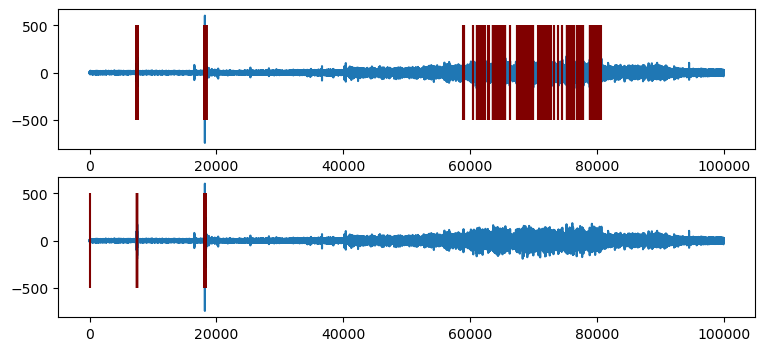

In [17]:
fig, ax = plt.subplots(2,1, figsize=(9,4))

ax[0].plot(time4,data4)
ax[0].vlines(time4[trig_thresh_idx], ymin=-500, ymax = 500, color="maroon")

ax[1].plot(time4,data4)
ax[1].vlines(time4[trig_segment], ymin=-500, ymax = 500, color="maroon")

plt.show()

## Figure 5

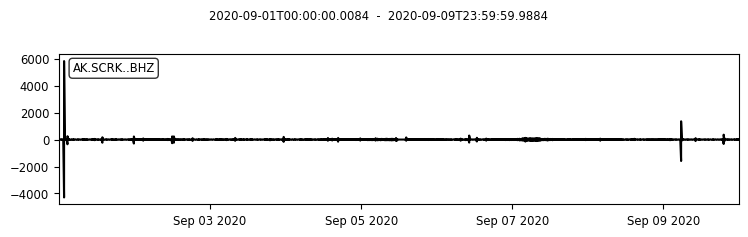

In [9]:
## using 10 day stream data from catalog building
## getting 10 day data from SCRK station\n",
## get SCRK station
starttime = obspy.UTCDateTime("2020-09-01T00:00:00")
endtime = obspy.UTCDateTime("2020-09-10T00:00:00")

inventory = client.get_stations(network="AK", station="SCRK")
SCRK_station = inventory[0].stations[0]

SCRK_stream = client.get_waveforms("AK", "SCRK", "*", "BHZ", starttime=starttime, endtime=endtime)
st = SCRK_stream.merge(method=0,fill_value=0).detrend().filter("bandpass", freqmin=2, freqmax=8)
st.plot()

trace = st[0]

SCRK_arrivaltimes = catalog_df.SCRKarrivaltime
SCRK_arrivaltimes_relative = np.array(SCRK_arrivaltimes)-trace.stats.starttime

In [13]:
## threshold triggering
data = trace.data
times = trace.times()

transmit_time = 30

trigger_thresholds = [30,40,50,70,90,120,150,180,200]
num_triggers_threshold = []
num_positive_triggers_threshold = []
num_negative_triggers_threshold = []

for threshold in trigger_thresholds:
    thresh_trig_idx = []
    
    i=0
    while i < len(data):
        if np.abs(data[i]) >= threshold:
            thresh_trig_idx.append(i)
            i+=int(transmit_time / trace.stats.delta)
        else:
            i+=1
    
    thresh_trig_idx = np.array(thresh_trig_idx)

    positive = 0
    negative = 0
    for trig_time in times[thresh_trig_idx]:
        time_diff = trig_time - SCRK_arrivaltimes_relative
        min_time_diff_idx = np.abs(time_diff).argmin()
        
        if (time_diff[min_time_diff_idx] <= 80.0) & (time_diff[min_time_diff_idx] >= -10.0):
            positive+=1
        else:
            negative+=1

    num_triggers_threshold.append(len(thresh_trig_idx))
    num_positive_triggers_threshold.append(positive)
    num_negative_triggers_threshold.append(negative)

# print(num_triggers_threshold, num_positive_triggers_threshold, num_negative_triggers_threshold)


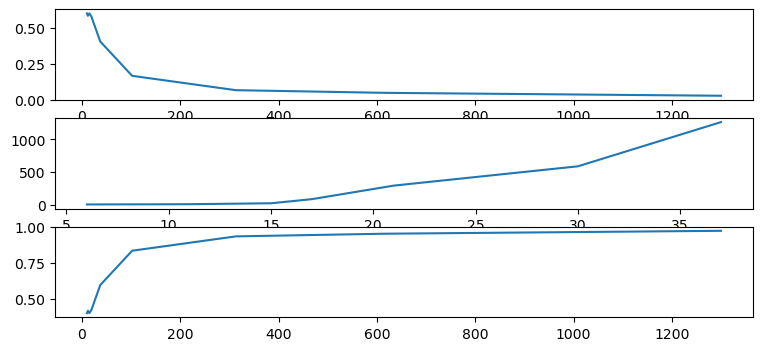

In [27]:
fig, ax = plt.subplots(3,1, figsize=(9,4))

ax[0].plot(np.array(num_triggers_threshold),np.array(num_positive_triggers_threshold)/np.array(num_triggers_threshold))
# ax[0].vlines(time4[trig_thresh_idx], ymin=-500, ymax = 500, color="maroon")
ax[1].plot(np.array(num_positive_triggers_threshold),np.array(num_negative_triggers_threshold))
ax[2].plot(np.array(num_triggers_threshold),np.array(num_negative_triggers_threshold)/np.array(num_triggers_threshold))
# ax[1].vlines(time4[trig_segment], ymin=-500, ymax = 500, color="maroon")

plt.show()

In [45]:
## sta/lta triggering
data = trace.data
times = trace.times()

fs = trace.stats.sampling_rate
cft = trigger.recursive_sta_lta(data, int(5 * fs), int(10 * fs))

## defione threshold above which to trigger (value from Tian et al.)
cft_thresholds = np.arange(1.57,1.99,0.03)
      
num_triggers_stalta = []
num_positive_triggers_stalta = []
num_negative_triggers_stalta = []

for threshold in cft_thresholds:
    cft_trig_idx = np.where(np.abs(data) >= cft_threshold)

    positive = 0
    negative = 0
    for trig_time in times[cft_trig_idx]:
        time_diff = trig_time - SCRK_arrivaltimes_relative
        min_time_diff_idx = np.abs(time_diff).argmin()
        
        if (time_diff[min_time_diff_idx] <= 80.0) & (time_diff[min_time_diff_idx] >= -10.0):
            positive+=1
        else:
            negative+=1

    num_triggers_stalta.append(len(cft_trig_idx[0]))
    num_positive_triggers_stalta.append(positive)
    num_negative_triggers_stalta.append(negative)

print(num_triggers_stalta, num_positive_triggers_stalta, num_negative_triggers_stalta)

14


KeyboardInterrupt: 

In [50]:
## segmented window triggering
data = trace.data
times = trace.times()

window_len = 120             ## defining window length in seconds ##
threshold_sw = range(20,200,10)

num_triggers_sw = []
num_positive_triggers_sw = []
num_negative_triggers_sw = []

## getting bounds for each window ##
window_bound = times[times%window_len==0]
window_bound_idx = np.array(np.where(times%window_len==0)[0])

for threshold in threshold_sw: 
    
    ## storing window mean and (left, right) bounds as pairs for easy plotting
    mean = []
    mean_minbounds = []
    mean_maxbounds = []
    trig_sw_idx = []

    ## arrays for diplacement ratio and cumulative sum of each window 
    ratio = np.zeros_like(data)
    running_sum = np.zeros_like(data)

    prev_idx=window_bound_idx[0]
    prev_mean = 1

    for idx in window_bound_idx[1:]:

        curr_window = data[prev_idx:idx]
        curr_mean = np.sum(np.abs(curr_window))/len(curr_window)

        mean.append(curr_mean)
        mean_minbounds.append(prev_idx)
        mean_maxbounds.append(idx)

        ratio[prev_idx:idx] = np.abs(curr_window)/np.abs(prev_mean)          ## ratioing current window values using previous window mean 

        running_sum[prev_idx:idx] = np.cumsum(np.abs(curr_window))/len(curr_window)           ## cumulative sum of values normalized to window size 

        # print(20*prev_mean)
        for i in range(prev_idx,idx):
            if data[i] >= threshold*prev_mean:
                trig_sw_idx.append(i)

        prev_idx=idx
        prev_mean = curr_mean
    mean = np.array(mean)
        
    positive = 0
    negative = 0
    for trig_time in times[trig_sw_idx]:
        time_diff = trig_time - SCRK_arrivaltimes_relative
        min_time_diff_idx = np.abs(time_diff).argmin()
        
        if (time_diff[min_time_diff_idx] <= 80.0) & (time_diff[min_time_diff_idx] >= -10.0):
            positive+=1
        else:
            negative+=1

    num_triggers_sw.append(len(trig_sw_idx))
    num_positive_triggers_sw.append(positive)
    num_negative_triggers_sw.append(negative)
    
print(num_triggers_sw, num_positive_triggers_sw, num_negative_triggers_sw)    

[19327, 13462, 10259, 8161, 6715, 5593, 4846, 4232, 3753, 3371, 3048, 2776, 2546, 2369, 2205, 2045, 1918, 1830] [7396, 5566, 4403, 3548, 2875, 2360, 2010, 1715, 1512, 1334, 1183, 1058, 943, 863, 777, 687, 625, 583] [11931, 7896, 5856, 4613, 3840, 3233, 2836, 2517, 2241, 2037, 1865, 1718, 1603, 1506, 1428, 1358, 1293, 1247]
